In [1]:
import xarray
import fiasco
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.visualization import LogStretch, ImageNormalize

# Analysis

In this notebook, perform density diagnostics, DEM inversion, intensity ratio, and time-lag analysis

In [2]:
eis_ds = xarray.open_dataset('../pipeline/data/EIS/loop_cutouts_no_background.nc')

## Density Diagnostic

In [3]:
def get_line_ratio(ion, density, numerator_transitions, denominator_transitions, **kwargs):
    """
    For a given ion and a range of densities, calculate the intensity ratio for a selected
    set of transitions at the formation temperature of the ion.
    """
    # Create a new Ion instance with a single temperature at the formation temperature
    ion = ion._new_instance(temperature=ion.formation_temperature)
    # Calculate contribution function
    g_of_nt = ion.contribution_function(density, **kwargs)
    # Get corresponding wavelengths
    w = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    # Find indices corresponding to numerator and denominator
    # NOTE: these are the closest wavelengths to those specified.
    i_numerator = [np.argmin(np.fabs(w - t)) for t in numerator_transitions]
    i_denominator = [np.argmin(np.fabs(w - t)) for t in denominator_transitions]
    # Take ratio of sums over numerator and denominator transitions
    ratio = g_of_nt[..., i_numerator].sum(axis=2) / g_of_nt[..., i_denominator].sum(axis=2)
    return ratio.squeeze()

In [4]:
def make_density_map(observed_ratio, density, intensity_ratio):
    """
    For a given intensity ratio curve and two associated intensity maps, calculate the resulting
    density map.
    """
    f_ratio_to_density = interp1d(intensity_ratio.decompose().value,
                                  density.value,
                                  bounds_error=False,
                                  fill_value=np.nan)
    observed_density = f_ratio_to_density(observed_ratio.data)
    observed_density = xarray.DataArray(observed_density, coords=observed_ratio.coords)
    observed_density.attrs['unit'] = density.unit.to_string()
    
    return observed_density

In [5]:
density = np.logspace(7,12,20) * u.Unit('cm-3')
temperature = np.linspace(1,2,1000)*u.MK
fe12 = fiasco.Ion('Fe XII', temperature)
fe13 = fiasco.Ion('Fe XIII', temperature)

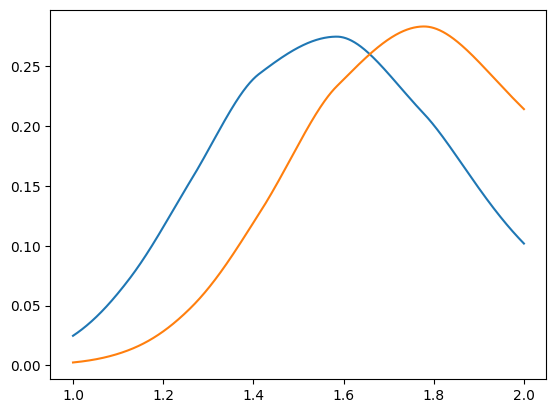

In [6]:
plt.plot(fe12.temperature, fe12.ioneq)
plt.plot(fe13.temperature, fe13.ioneq)

In [7]:
intensity_ratio_fe12 = get_line_ratio(fe12, density, [186.854, 186.887] * u.angstrom, [195.119] * u.angstrom)
intensity_ratio_fe13 = get_line_ratio(fe13, density, [203.795, 203.826] * u.angstrom, [202.044] * u.angstrom)

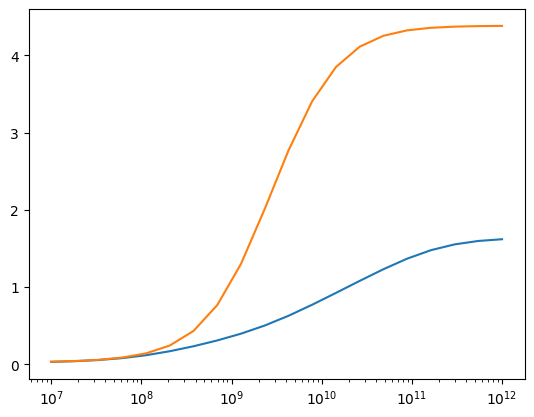

In [8]:
plt.plot(density, intensity_ratio_fe12)
plt.plot(density, intensity_ratio_fe13)
plt.xscale('log')

In [9]:
observed_ratio_fe12 = eis_ds['Fe XII 186.880_intensity'] / eis_ds['Fe XII 195.119_intensity']
observed_ratio_fe13 = eis_ds['Fe XIII 203.826_intensity'] / eis_ds['Fe XIII 202.044_intensity']

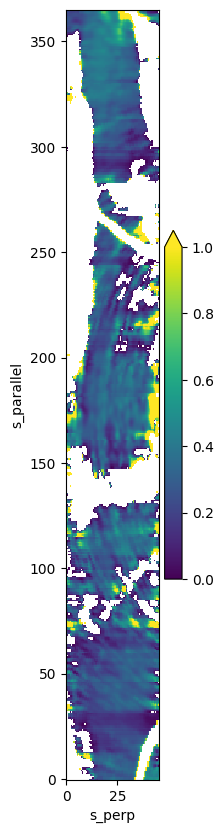

In [10]:
observed_ratio_fe12.plot.imshow(size=10, aspect=0.15, vmin=0, vmax=1)

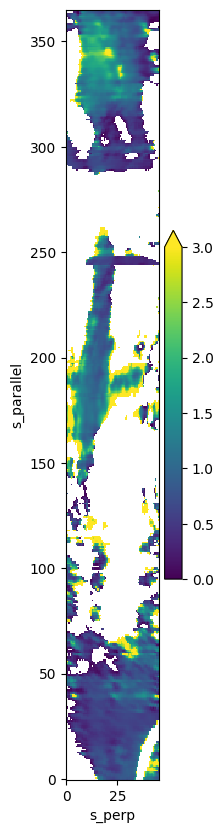

In [11]:
observed_ratio_fe13.plot.imshow(size=10, aspect=0.15, vmin=0, vmax=3)

In [12]:
f_ratio_to_density = interp1d(intensity_ratio_fe12.decompose().value,
                              density.value,
                              bounds_error=False,
                              fill_value=np.nan)
observed_density_fe12 = f_ratio_to_density(observed_ratio_fe12.data)
observed_density_fe12 = xarray.DataArray(observed_density_fe12, coords=observed_ratio_fe12.coords)

In [13]:
observed_density_fe12 = make_density_map(observed_ratio_fe12, density, intensity_ratio_fe12)

In [14]:
observed_density_fe13 = make_density_map(observed_ratio_fe13, density, intensity_ratio_fe13)

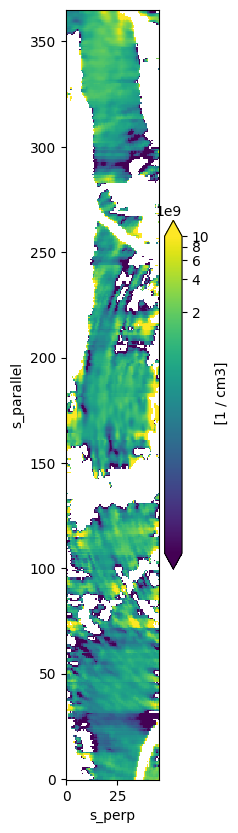

In [15]:
observed_density_fe12.plot.imshow(size=10, aspect=0.15, norm=ImageNormalize(vmin=1e8, vmax=1e10, stretch=LogStretch()))

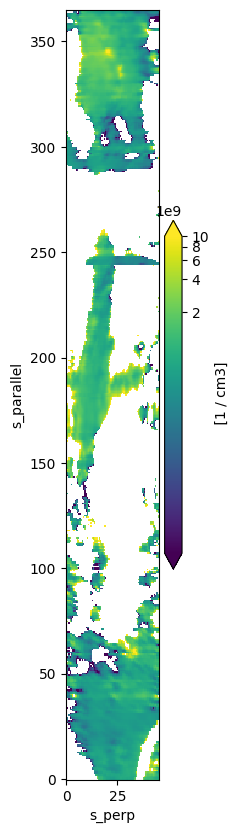

In [16]:
observed_density_fe13.plot.imshow(size=10, aspect=0.15, norm=ImageNormalize(vmin=1e8, vmax=1e10, stretch=LogStretch()))

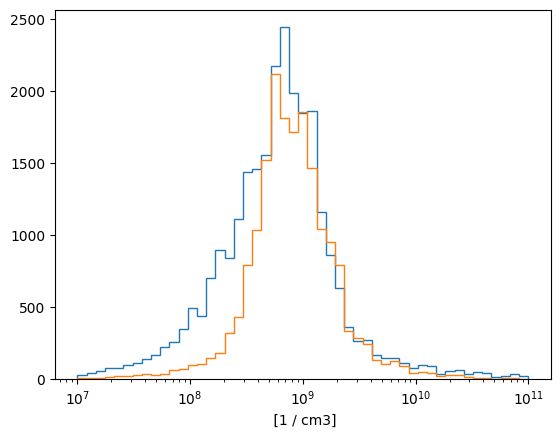

In [17]:
bins = np.logspace(7,11,50)
observed_density_fe12.plot.hist(bins=bins, histtype='step')
observed_density_fe13.plot.hist(bins=bins, histtype='step')
plt.xscale('log')

## DEM Analysis

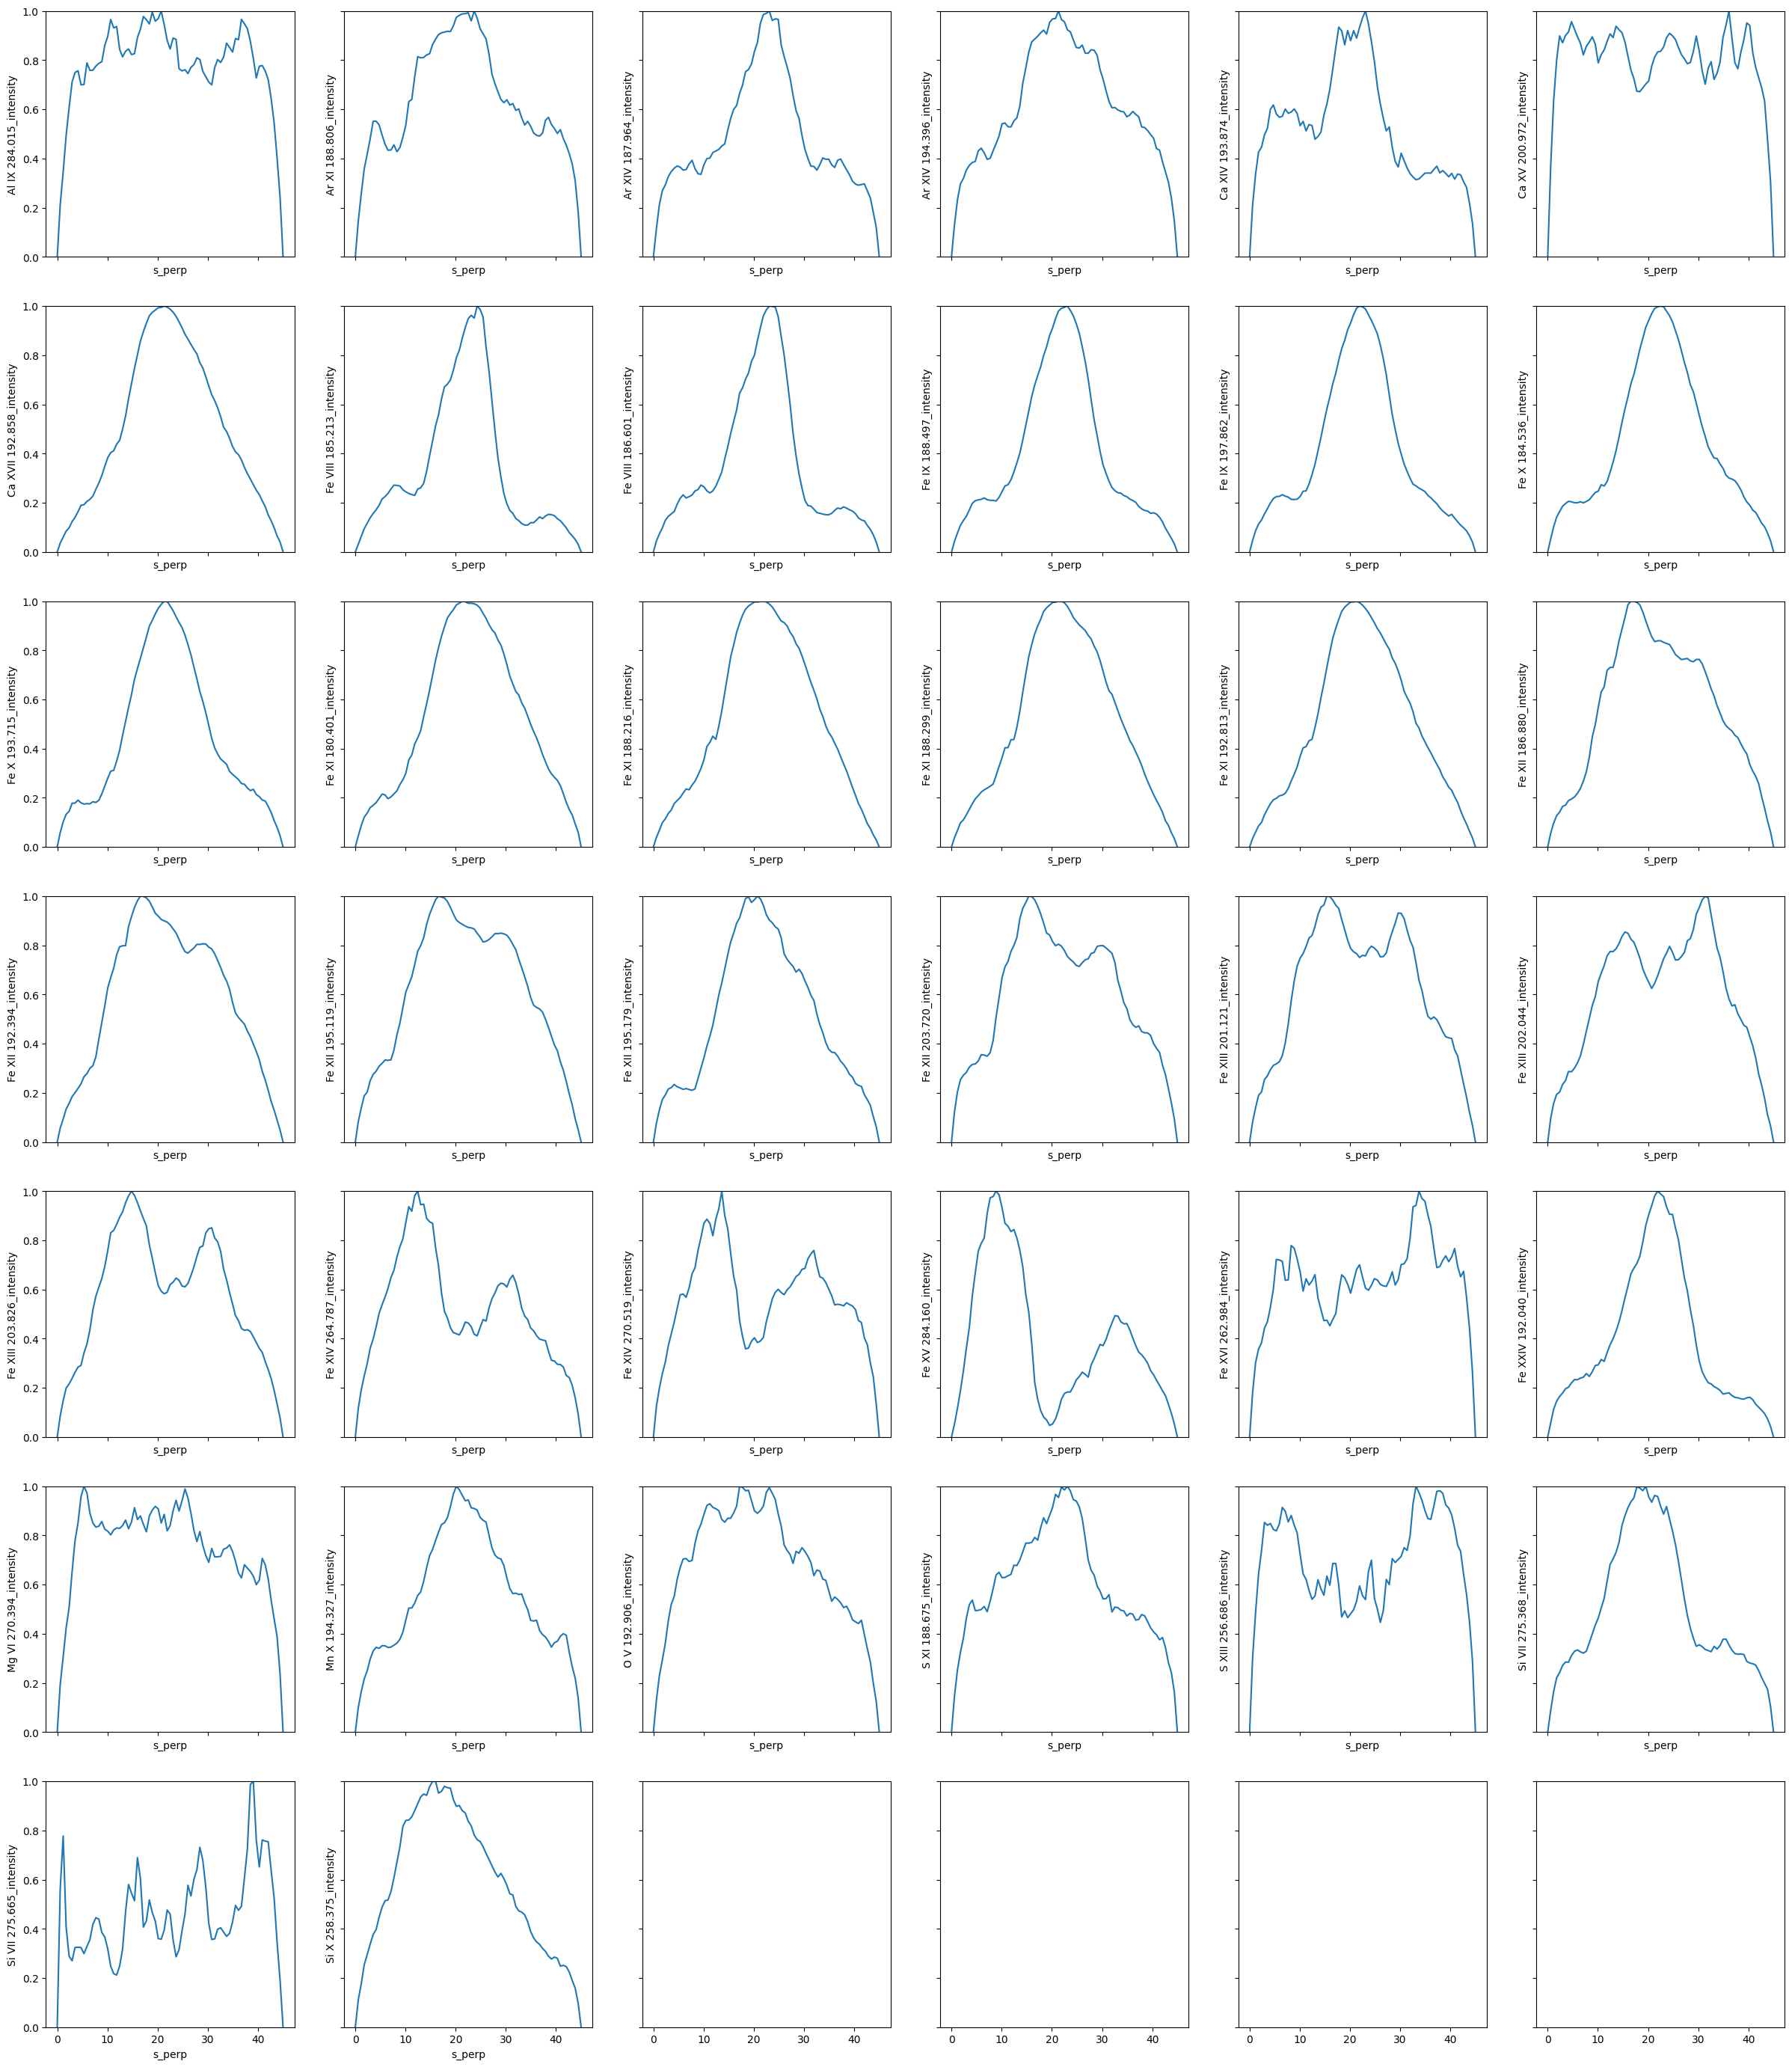

In [20]:
fig,axes = plt.subplots(7,6,figsize=(30,35),sharex=True, sharey=True)
for k,ax in zip(eis_ds.keys(), axes.flatten()):
    mean_intensity = eis_ds[k].mean(dim='s_parallel', skipna=True)
    mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.set_ylim(0,1)